# LUMEN Data Science 2nd workshop

<body>
    <div style="float:left;">
        <h2> TurboFan predictive maintenance - simple modelling </h2>
    </div>
    <div>
        <img src="http://www.megatrend.com/wp-content/uploads/2015/11/MPR_logo_horizontalni_300px1.png" alt="MPR logo" style="float:left;"/> 
    </div> 
</body>

Dataset:
<a href="https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/">Turbofan Engine Degradation Simulation Data Set</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.metrics import max_error
from sklearn import preprocessing

plt.style.use('ggplot')
%matplotlib inline  

In [2]:
column_names = ['id','cycle','setting1','setting2','setting3',
                's1','s2','s3','s4','s5','s6','s7','s8','s9',
                's10','s11','s12','s13','s14','s15','s16','s17',
                's18','s19','s20','s21', 's22', 's23']

## 1. Loading our data

**Let's check out the readme file:**

In [3]:
with open('CMAPSSData/readme.txt', 'rb') as f:
     lines = [l.decode('utf8', 'ignore') for l in f.readlines()]
f.close()

In [4]:
lines

['Data Set: FD001\n',
 'Train trjectories: 100\n',
 'Test trajectories: 100\n',
 'Conditions: ONE (Sea Level)\n',
 'Fault Modes: ONE (HPC Degradation)\n',
 '\n',
 'Data Set: FD002\n',
 'Train trjectories: 260\n',
 'Test trajectories: 259\n',
 'Conditions: SIX \n',
 'Fault Modes: ONE (HPC Degradation)\n',
 '\n',
 'Data Set: FD003\n',
 'Train trjectories: 100\n',
 'Test trajectories: 100\n',
 'Conditions: ONE (Sea Level)\n',
 'Fault Modes: TWO (HPC Degradation, Fan Degradation)\n',
 '\n',
 'Data Set: FD004\n',
 'Train trjectories: 248\n',
 'Test trajectories: 249\n',
 'Conditions: SIX \n',
 'Fault Modes: TWO (HPC Degradation, Fan Degradation)\n',
 '\n',
 '\n',
 '\n',
 'Experimental Scenario\n',
 '\n',
 'Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine  i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees

In [5]:
# you can use the Linux method as well :)
#!cat 'CMAPSSData/readme.txt' 

**We will be using only FD001 data, since there are multiple scenarios present in this dataset.**

In [5]:
GT_doc = 'CMAPSSData/RUL_FD001.txt'
train_doc = 'CMAPSSData/train_FD001.txt' 
test_doc = 'CMAPSSData/test_FD001.txt'

In [6]:
train_data = pd.read_csv(train_doc, sep=' ', names = column_names)
test_data = pd.read_csv(test_doc, sep=' ', names = column_names)
gt_data = pd.read_csv(GT_doc, sep=' ', header=None)

## 2. Basic data exploration

In [7]:
train_data.head()W

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [9]:
test_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [10]:
gt_data.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


### No. of unique motors in the dataset FD001

In [13]:
train_data.id.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

### Drop extra columns

In [14]:
train_data.drop(columns=['s22', 's23'], inplace=True)
test_data.drop(columns=['s22', 's23'],  inplace=True)

In [15]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [16]:
train_data.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


### ! Checking for missing values !

<font size="3">In case of missing (NULL / NaN) values, it is generally neccessary to replace these values with those of neighbouring rows/cells in adequate fashion. This primarily depends on your data and the use-case that you are solving. 

Most of the time a mean or median values would be used (considering the column or row), as well as zeros in case of numerical data. There is also an option to drop the missing values(rows), but there is a possibility that by doing that, you would be losing valuable information. Furthermore, there are a number of algorithms that support data with missing values, but most of the time you should not rely on it, but instead try your best to replace them.

**Luckily enough, this data comes without missing values, but that might not be the case for the data you were provided with.** 


helpful links:

* https://lmgtfy.com/?q=how+to+replace+missing+values+in+python

* https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

* https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

* https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

* https://machinelearningmastery.com/handle-missing-data-python/
</font>

In [17]:
train_data.isnull().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

In [18]:
 test_data.isnull().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

In [19]:
train_data.dtypes

id            int64
cycle         int64
setting1    float64
setting2    float64
setting3    float64
s1          float64
s2          float64
s3          float64
s4          float64
s5          float64
s6          float64
s7          float64
s8          float64
s9          float64
s10         float64
s11         float64
s12         float64
s13         float64
s14         float64
s15         float64
s16         float64
s17           int64
s18           int64
s19         float64
s20         float64
s21         float64
dtype: object

### Max no. of cycles

In [20]:
train_data['cycle'].max()

362

In [21]:
test_data['cycle'].max()

303

### Preview last cycles in training data - neccessary for TTF (time to failure) regression variable

In [22]:
df_last_cycle = pd.DataFrame(train_data.groupby('id')['cycle'].max())
df_last_cycle.reset_index(level=0 , inplace=True)
df_last_cycle.columns = ['id', 'last_cycle']
df_last_cycle.describe()

,id,last_cycle
count,100.000000,100.000000
mean,50.500000,206.310000
std,29.011492,46.342749
min,1.000000,128.000000
25%,25.750000,177.000000
50%,50.500000,199.000000
75%,75.250000,229.250000
max,100.000000,362.000000


In [23]:
df_last_cycle.head()

,id,last_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


### Formatting the ground truth data

In [24]:
gt_data.columns = ['ttf','1']
gt_data=gt_data.drop(columns=['1'])
gt_data.head()

,ttf
0,112
1,98
2,69
3,82
4,91


In [25]:
gt_data.describe()

,ttf
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


### Plotting basic data

In [26]:
train_data.cycle.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [27]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [29]:
idxs = [10, 30, 50]
colors = ['#3B9AB2', '#EBCC2A', '#F21A00']

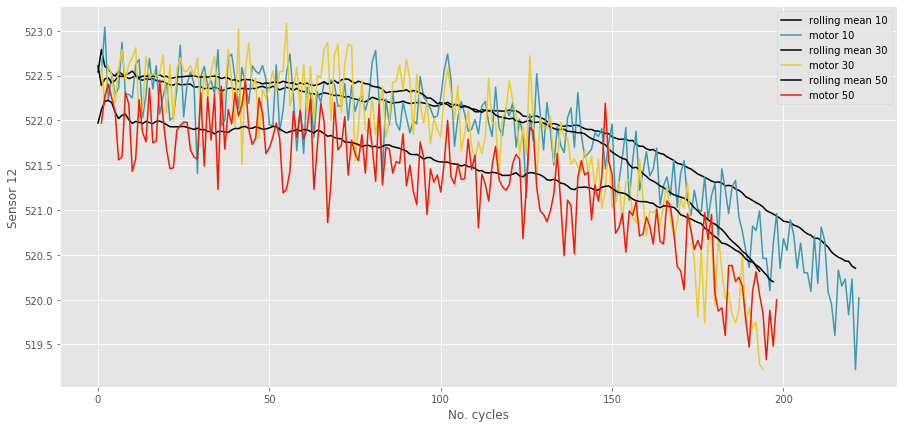

In [30]:
fig, ax1 = plt.subplots(figsize=(15,7))
plt.xlabel('No. cycles')
plt.ylabel('Sensor 12')

for i in range(len(idxs)):
    temp = train_data[train_data['id'] == idxs[i]]['s12'].rolling(30, min_periods = 1).mean().reset_index(0,drop=True)
    plt.plot(temp, label = 'rolling mean ' + str(idxs[i]), color='black')
    plt.plot(train_data[train_data['id'] == idxs[i]]['cycle'], 
             train_data[train_data['id'] == idxs[i]]['s12'], label = 'motor '+ str(idxs[i]),
            color=colors[i])
    
plt.legend()
plt.show()

## 3. Constructing features: Feature Engineering for Time Series

In [31]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Adding simple lag features for sensor data -  train & test

In [32]:
def add_lag_features(df_in, num_lags):
    
    df_temp = df_in.copy()
    #define our sensor cols
    sensor_cols = [col for col in df_in.iloc[:, 2:]] 
    
    for sensor in sensor_cols:
        for lag in range(1,num_lags+1):
            df_temp[str(sensor) + '_lag_' + str(lag)] = df_temp.groupby('id').shift(lag)[sensor].bfill()

    return df_temp

Now we can verify that we have added quite a lot of columns to our dataset.

In [32]:
#train_data_features.shape, test_data_features.shape

### Adding extra features utilizing rolling window 

*Based on smoothing the time series for sensors by adding rolling mean and rolling standard deviation by using* **pd.DataFrame.rolling**

In [34]:
??pd.DataFrame.rolling

In [35]:
def add_rolling_features(df_in, rolling_win_size, wanted_features):
    
    #sensor_cols = [col for col in train_data.iloc[:, 5:]]    
    sensor_cols = [col for col in wanted_features[2:]] 

    sensor_av_cols = [s.replace('s', 'av') for s in sensor_cols]
    sensor_sd_cols = [s.replace('s', 'sd') for s in sensor_cols]
    
    df_out = pd.DataFrame()
    
    ws = rolling_win_size
    
    # calculate rolling stats for each engine id
    for eng_id in pd.unique(df_in.id):
        
        df_engine = df_in[df_in['id'] == eng_id]
        df_sub = df_engine[sensor_cols]
        
        av = df_sub.rolling(ws, min_periods = 1).mean()
        av.columns = sensor_av_cols
        
        sd = df_sub.rolling(ws, min_periods = 1).std().fillna(0)
        sd.columns = sensor_sd_cols
        
        new_features = pd.concat([df_engine, av, sd], axis = 1)
        
        df_out = pd.concat([df_out, new_features])
    
    return df_out

### Calculate TTF feature for training data

We are preparing datasets by adding TTF variable and a classification variable dependant on a window that we want to predict. We will not be modelling classification in this workshop, but you can still play around with the data yourself afterwards.

In [36]:
def prepare_training_data(df_in, period):
    
    # make a dataframe to hold the last cycle for each enginge in the dataset
    df_max_cycle = pd.DataFrame(df_in.groupby('id')['cycle'].max())
    
    df_max_cycle.reset_index(level = 0, inplace = True)
    df_max_cycle.columns = ['id', 'last_cycle']
    
    # add time-to-failure column as a regression label   
    df_in = pd.merge(df_in, df_max_cycle, on='id')
    df_in['ttf'] = df_in['last_cycle'] - df_in['cycle']
    df_in.drop(['last_cycle'], axis = 1, inplace = True)
    
    # create binary classification label
    df_in['label_bnc'] = df_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    return df_in

Our test data is prepared in a different fashion, since we are merging ground truth data in order to add the TTF variable.

In [37]:
def prepare_test_data(df_test_in, df_truth_in, period):
        
    df_tst_last_cycle = pd.DataFrame(df_test_in.groupby('id')['cycle'].max())
    
    df_tst_last_cycle.reset_index(level=0, inplace=True)
    df_tst_last_cycle.columns = ['id', 'last_cycle']
    df_test_in = pd.merge(df_test_in, df_tst_last_cycle, on='id')
    df_test_in = df_test_in[df_test_in['cycle'] == df_test_in['last_cycle']]

    # remove the last cycle column
    df_test_in.drop(['last_cycle'], axis=1, inplace=True)    
    df_test_in.reset_index(drop=True, inplace=True)
    
    df_test_in = pd.concat([df_test_in, gt_data], axis=1)
    
    # create binary classification label
    df_test_in['label_bnc'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    return df_test_in

## 4. Original data preparation

*We are preparing original data in order to be able to model it and **compare** it using the same approach that we use with data with extra features.*

In [38]:
train_data_original_prepared = prepare_training_data(train_data, 5)
train_data_original_prepared.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [39]:
test_data_original_prepared = prepare_test_data(test_data, gt_data, 30)
test_data_original_prepared.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,112,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,98,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,69,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581,82,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117,91,0


In [40]:
train_data_original_prepared.shape, test_data_original_prepared.shape

((20631, 28), (100, 28))

In [41]:
train_data_original_prepared.to_csv('train_data_original.csv', index = False)
test_data_original_prepared.to_csv('test_data_original.csv', index = False)

### Let's plot and compare the standard deviation of original features

In [42]:
features = [col for col in train_data.iloc[:,2:]]

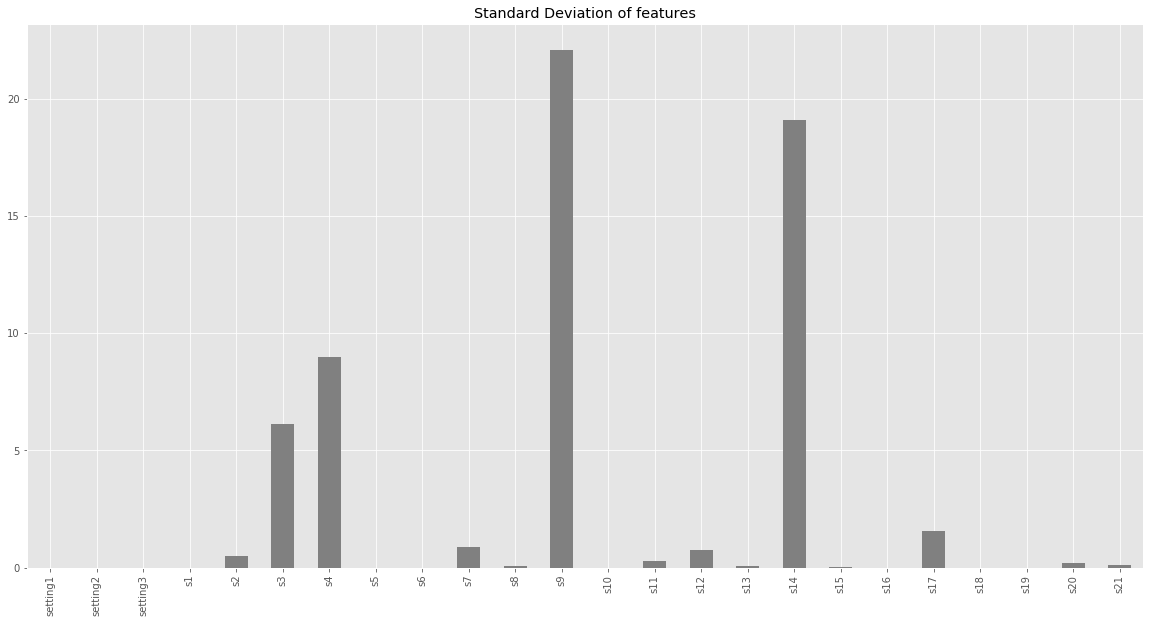

In [43]:
train_data[features].std().plot(kind='bar', figsize=(20,10), title="Standard Deviation of features", color='grey')

For features **setting1, setting2, setting3, s1, s5, s6, s10, s16, s18 and s19** we can see that standard deviation on these features is 0. We do not have enough information on the sensors in question, and the depicted graph here is used to visualize the amount of variation in our data.

In [44]:
train_data

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


We will add a regression variable TTF, or time-to-failure in order to correlate existing features with it and find out which features are more or less important.

In [45]:
train_data_TTF = prepare_training_data(train_data, 30)

In [46]:
train_data_TTF.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [47]:
train_data_TTF.iloc[:, 5:-1].head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Drop columns 's18' and 's19'

In [50]:
train_data_TTF = train_data_TTF.drop(columns = ['s18', 's19'])

In [51]:
train_corr_TTF = train_data_TTF.iloc[:, 5:-1].corr()

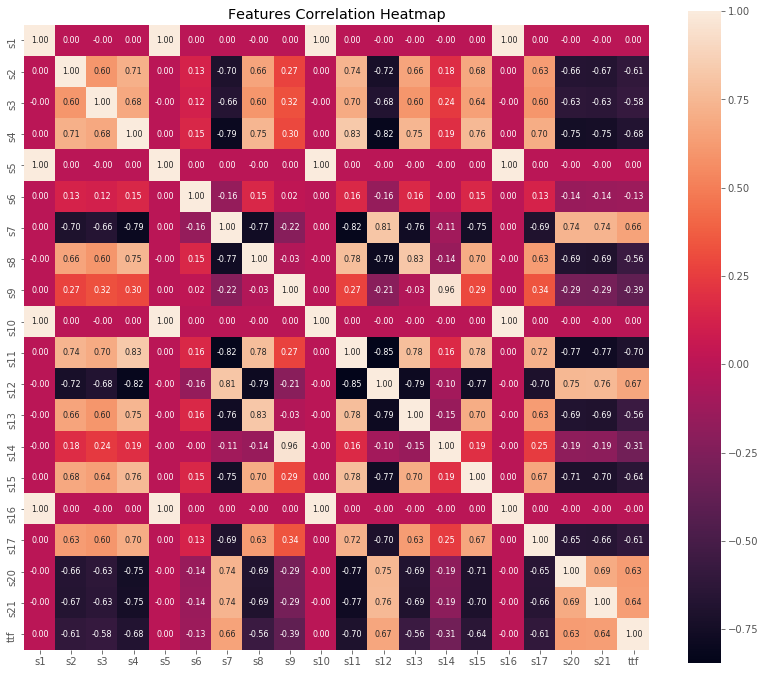

In [52]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(train_corr_TTF, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=train_corr_TTF, xticklabels=train_corr_TTF)
plt.title('Features Correlation Heatmap')
plt.show()

Looking at our data, we can see that the lowest correlation with 'ttf' is produced with features s1, s5, s10 and s16 (there is no correlation).

There are a number of other features that seem to have lower correlation with 'ttf' feature, and there are pairs of features that also highly correlate with each other. This might prove to be an issues when building models that depend on these features.

In [53]:
train_corr_TTF = train_data_TTF.iloc[:, 5:-1].corr()
c = train_corr_TTF.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

If we take a look at these pairs of correlations, it is evident that some features highly correlate with each other (>|0.8|), and we can use this information to test out our models with and without mentioned features. 

In [54]:
so[:50]

ttf  ttf    1.000000
s20  s20    1.000000
s16  s16    1.000000
     s10    1.000000
     s5     1.000000
     s1     1.000000
s15  s15    1.000000
s14  s14    1.000000
s13  s13    1.000000
s12  s12    1.000000
s11  s11    1.000000
s10  s16    1.000000
     s10    1.000000
     s5     1.000000
     s1     1.000000
s9   s9     1.000000
s8   s8     1.000000
s7   s7     1.000000
s6   s6     1.000000
s5   s16    1.000000
     s10    1.000000
     s5     1.000000
     s1     1.000000
s4   s4     1.000000
s3   s3     1.000000
s2   s2     1.000000
s1   s16    1.000000
     s10    1.000000
     s5     1.000000
s17  s17    1.000000
s1   s1     1.000000
s21  s21    1.000000
s14  s9     0.963157
s9   s14    0.963157
s12  s11    0.846884
s11  s12    0.846884
s4   s11    0.830136
s11  s4     0.830136
s13  s8     0.826084
s8   s13    0.826084
s7   s11    0.822805
s11  s7     0.822805
s4   s12    0.815591
s12  s4     0.815591
s7   s12    0.812713
s12  s7     0.812713
s7   s4     0.793130
s4   s7     0

In [55]:
removal_corr = ['s1', 's5', 's6', 's10', 's16', 'setting1', 'setting2', 'setting3']

Beacuse of the high correlation between pairs of sensors you could exclude these from your models and observe results in both scenarios. For now, we will leave them in the dataset.

In [53]:
mutual_corr = ['s9', 's8', 's7']

In [56]:
train_data_TTF.drop(columns=removal_corr, inplace=True)

In [57]:
train_data_TTF.iloc[:, 2:-2].columns

Index(['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15',
       's17', 's20', 's21'],
      dtype='object')

We will be saving **selected features** in a separate list for further manipulation.

In [58]:
selected_features = train_data_TTF.iloc[:, :-2].columns

In [59]:
selected_features

Index(['id', 'cycle', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
       's14', 's15', 's17', 's20', 's21'],
      dtype='object')

## 4b. (optional) Scaling data and selecting features

**[This section is meant to be used for a variety of data preparation approaches, but can still be helpful with your data]**

### Scaling data (standardizing)

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler(copy = True)
scaler.fit(train_data_TTF.iloc[:, 2:-2])
train_data_TTF_scaled = scaler.transform(train_data_TTF.iloc[:, 2:-2])

In [63]:
train_data_TTF_scaled

array([[-1.72172539, -0.13425518, -0.92593596, ..., -0.78170979,
         1.34849274,  1.19442705],
       [-1.06177971,  0.21152849, -0.64372587, ..., -0.78170979,
         1.01652793,  1.23692196],
       [-0.66181262, -0.41316559, -0.52595315, ..., -2.07309423,
         0.73989059,  0.50342281],
       ...,
       [ 1.47801126,  1.94697106,  2.13837684, ...,  3.09244354,
        -2.08181033, -3.29248147],
       [ 1.09804254,  2.40366648,  1.95505138, ...,  1.15536688,
        -2.91172236, -2.08507166],
       [ 2.33794049,  1.60771161,  2.57835793, ...,  1.8010591 ,
        -2.46910261, -2.19408035]])

### Tree Based Feature selection

In [64]:
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(train_data_TTF_scaled, train_data_TTF['ttf'])

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [65]:
# display the relative importance of each attribute
for feature, importance in zip(train_data_TTF.iloc[:, 2:-2].columns, model.feature_importances_):
    print(feature, ": ", importance)

s2 :  0.07389661873437273
s3 :  0.0741128346873858
s4 :  0.07495012112675388
s7 :  0.0741694070652344
s8 :  0.06869296693030175
s9 :  0.07493964026607838
s11 :  0.07416545834300803
s12 :  0.0737285394933295
s13 :  0.06869149863686651
s14 :  0.07422639997638329
s15 :  0.07422742218020983
s17 :  0.04787994930300891
s20 :  0.07222025506304164
s21 :  0.0740988881940255


### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 100, n_jobs=-1)

# create the RFE model and select [n] attributes
rfe = RFE(model, 10)
rfe = rfe.fit(train_data_TTF_scaled, train_data_TTF['ttf'])

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

## 5.1 Adding created features - expanding the dataset

In [66]:
train_data.columns, train_data.shape

(Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21'],
       dtype='object'), (20631, 26))

### Selecting certain features (correlation graph) 

We will select a subset of our data by taking only a portion of features for modelling and feature extraction.

In [67]:
train_data_features = train_data[selected_features]
test_data_features = test_data[selected_features]

In [68]:
train_data_features.shape

(20631, 16)

We will add rolling windows for STD and mean.

In [69]:
train_data_features = add_rolling_features(train_data_features, 100, selected_features)
test_data_features = add_rolling_features(test_data_features, 100, selected_features)

In [70]:
test_data_features.head()

,id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,sd8,sd9,sd11,sd12,sd13,sd14,sd15,sd17,sd20,sd21
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,...,0.021213,3.005204,0.212132,0.311127,0.021213,9.948992,0.017607,0.707107,0.113137,0.012799
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,...,0.020817,3.430700,0.173205,0.220681,0.017321,7.179807,0.032155,0.577350,0.113725,0.021642
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,...,0.017078,5.115160,0.153623,0.337182,0.015000,5.890096,0.027781,0.957427,0.093095,0.020353
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,...,0.017889,5.465965,0.135720,0.329742,0.014142,5.222300,0.024080,1.303840,0.080623,0.020672


Add lag features with a defined period.

In [71]:
train_data_features = add_lag_features(train_data_features, 10)
test_data_features = add_lag_features(test_data_features, 10)

In [72]:
train_data_features.head()

,id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,sd21_lag_1,sd21_lag_2,sd21_lag_3,sd21_lag_4,sd21_lag_5,sd21_lag_6,sd21_lag_7,sd21_lag_8,sd21_lag_9,sd21_lag_10
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,0.003253,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,0.044573,0.003253,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,0.037977,0.044573,0.003253,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding final touches (ttf variable with classification variable) to both datasets

In [73]:
train_data_prepared = prepare_training_data(train_data_features, 30)
test_data_prepared = prepare_test_data(test_data_features, gt_data, 30)

In [74]:
train_data_prepared.head()

,id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,sd21_lag_3,sd21_lag_4,sd21_lag_5,sd21_lag_6,sd21_lag_7,sd21_lag_8,sd21_lag_9,sd21_lag_10,ttf,label_bnc
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190,0
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189,0
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188,0
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,0.003253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187,0


In [75]:
test_data_prepared.head()

,id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,sd21_lag_3,sd21_lag_4,sd21_lag_5,sd21_lag_6,sd21_lag_7,sd21_lag_8,sd21_lag_9,sd21_lag_10,ttf,label_bnc
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,...,0.035907,0.036118,0.036746,0.037156,0.037951,0.038650,0.037065,0.037952,112,0
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,...,0.064608,0.064043,0.064648,0.065186,0.065671,0.064573,0.065314,0.065680,98,0
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,...,0.063286,0.063195,0.063229,0.062656,0.061910,0.061236,0.062448,0.063018,69,0
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,...,0.059806,0.060246,0.059663,0.058224,0.058126,0.058364,0.058230,0.058497,82,0
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,...,0.059992,0.059954,0.058583,0.058623,0.058615,0.058692,0.058510,0.057270,91,0


### Exporting data - ease of use for later on

In [76]:
train_data_prepared.to_csv('train_prepared.csv', index=False)
test_data_prepared.to_csv('test_prepared.csv', index=False)

## 6. Creating simple regression models for our data

In [77]:
df_train = pd.read_csv('train_prepared.csv')
df_test = pd.read_csv('test_prepared.csv')

In [78]:
X_train = df_train.iloc[:, 2:-2]
y_train = df_train['ttf']

X_test = df_test.iloc[:, 2:-2]
y_test = df_test['ttf']

In [80]:
X_test.head()

,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,...,sd21_lag_1,sd21_lag_2,sd21_lag_3,sd21_lag_4,sd21_lag_5,sd21_lag_6,sd21_lag_7,sd21_lag_8,sd21_lag_9,sd21_lag_10
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,...,0.035165,0.035409,0.035907,0.036118,0.036746,0.037156,0.037951,0.038650,0.037065,0.037952
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,...,0.063373,0.063964,0.064608,0.064043,0.064648,0.065186,0.065671,0.064573,0.065314,0.065680
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,...,0.063087,0.062950,0.063286,0.063195,0.063229,0.062656,0.061910,0.061236,0.062448,0.063018
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,...,0.059976,0.059927,0.059806,0.060246,0.059663,0.058224,0.058126,0.058364,0.058230,0.058497
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,...,0.059774,0.060083,0.059992,0.059954,0.058583,0.058623,0.058615,0.058692,0.058510,0.057270


### 6.1 (optional) Normalization - use only one

#### 6.1.1 MinMax normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)

In [ ]:
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)

In [ ]:
X_test_scaled

#### 6.1.2. Standard scale normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True)

In [ ]:
X_train_scaled = scaler.fit_transform(df_train.iloc[:, 2:-2])
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)

In [ ]:
X_test_scaled = scaler.fit_transform(df_test.iloc[:, 2:-2])
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)

In [ ]:
X_test_scaled.head()

### 6.2 Load original data

In [81]:
train_data_orig = pd.read_csv('train_data_original.csv')
test_data_orig = pd.read_csv('test_data_original.csv')

In [73]:
#train_data_orig = prepare_training_data(train_data, 30)
#test_data_orig = prepare_test_data(test_data, gt_data, 30)

In [82]:
X_train_original = train_data_orig.iloc[:, 2:-2]
y_train_original = train_data_orig['ttf']

X_test_original = test_data_orig.iloc[:, 2:-2]
y_test_original = test_data_orig['ttf']

We can see again that original data has 24 colums, while our newly generated dataset with features has quite a lot more columns.

In [83]:
X_train_original.shape[1], X_train.shape[1]

(24, 462)

In [84]:
X_test_original.shape, X_test.shape

((100, 24), (100, 462))

In [85]:
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: ttf, dtype: int64

In [78]:
X_train.isnull().sum().sum()

0

### 6.3 Define regression metrics

In order to measure how good is the model performance, we will use several known regression metrics such as:
RMSE, MAE, R^2, etc.

In [86]:
def get_regression_metrics(model, actual, predicted):

    x= np.mean(np.abs((actual - predicted) / actual)) * 100
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted),
                        'Max Error' : metrics.max_error(actual, predicted),
                        'Mean absolute percentage error': x
               
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

<img src="https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2015/03/residual.png"/>

*Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results.*

<a href="https://www.statisticshowto.datasciencecentral.com/rmse/">Source</a>

### 6.4 Linear Regression model

To test the simples model, we will try to fit linear regression on our data and compare the performance.

In [87]:
linreg = linear_model.LinearRegression()
linereg_orig = linear_model.LinearRegression()

In [88]:
linreg.fit(X_train, y_train)
linereg_orig.fit(X_train_original, y_train_original)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

y_test_predict_orig = linereg_orig.predict(X_test_original)
y_train_predict_orig = linereg_orig.predict(X_train_original)

In [90]:
linreg_metrics = get_regression_metrics('Linear Regression with features', y_test, y_test_predict)
linreg_metrics_orig = get_regression_metrics('Linear Regression original', y_test_original, y_test_predict_orig)

In [91]:
linreg_metrics

,Linear Regression with features
Root Mean Squared Error,27.127608
Mean Absolute Error,22.166660
R^2,0.573849
Explained Variance,0.701903
Max Error,77.623348
Mean absolute percentage error,57.922984


In [92]:
linreg_metrics_orig

,Linear Regression original
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297
Max Error,78.745622
Mean absolute percentage error,55.357098


### 6.5 XGBoost model

Let's try out a different model using decision trees and gradient boosting - decision trees are immune to multi-collinearity, so you could test your models with features that we filtered out beforehand.

In [93]:
import xgboost as xgb

In [94]:
data_matrix = xgb.DMatrix(data=X_train, label= y_train)
data_matrix_orig = xgb.DMatrix(data = X_train_original, label = y_train_original)

/home/redshift/anaconda3/envs/jnb/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/redshift/anaconda3/envs/jnb/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [95]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [96]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                           max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10, 
                          n_jobs = -1, 
                          tree_method='gpu_hist')

#if you want to run GridSearchCV, you can initialize a "clean" XGBRegressor instance
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

In [97]:
xg_reg_orig = xgb.XGBRegressor(objective ='reg:squarederror', 
                               colsample_bytree = 0.3, 
                               learning_rate = 0.1,
                               max_depth = 5, 
                               alpha = 10,
                               n_estimators = 10,
                               n_jobs = -1, 
                               tree_method='gpu_hist')

### 6.5.1 Parameter grid search

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.3, 0.8, 1.0],
        'max_depth': [5, 6, 8],
        'n_estimators':[10,15,20],
        'learning_rate': [0.1, 0.01, 0.15]
        }

In [ ]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)

random_search = GridSearchCV(xg_reg, 
                             param_grid=params, 
                             scoring='neg_root_mean_squared_error', 
                             cv=skf.split(X_train, y_train), 
                             verbose=1,
                            n_jobs=-1)

random_search.fit(X_train, y_train)

In [ ]:
print(random_search.best_estimator_)
print(random_search.best_score_)
print(random_search.best_index_)

In [ ]:
random_search.cv_results_['params'][random_search.best_index_]

In [ ]:
pd.DataFrame(random_search.cv_results_).to_csv('grid_search_params.csv')

### predictions

In [98]:
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

In [99]:
xg_reg_orig.fit(X_train_original,  y_train_original)
preds_orig = xg_reg_orig.predict(X_test_original)

In [100]:
#preds = random_search.predict(X_test)

In [101]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse_orig = np.sqrt(mean_squared_error(y_test_original, preds_orig))

print("model with extra features RMSE: %f" % (rmse))
print("original features RMSE: %f" % (rmse_orig))

model with extra features RMSE: 23.480178
original features RMSE: 24.387860


### 6.6 Let's combine the models - ensemble

In [102]:
combined_pred = (preds + y_test_predict)/2
combined_pred_original = (preds_orig + y_test_predict_orig)/2

In [103]:
rmse_combined = np.sqrt(mean_squared_error(y_test, combined_pred))
rmse_combined_original = np.sqrt(mean_squared_error(y_test_original, combined_pred_original))

In [104]:
print("combined RMSE: %f" % (rmse_combined))
print("combined original RMSE: %f" % (rmse_combined_original))

combined RMSE: 15.531822
combined original RMSE: 20.635277


In [106]:
from seaborn import regplot

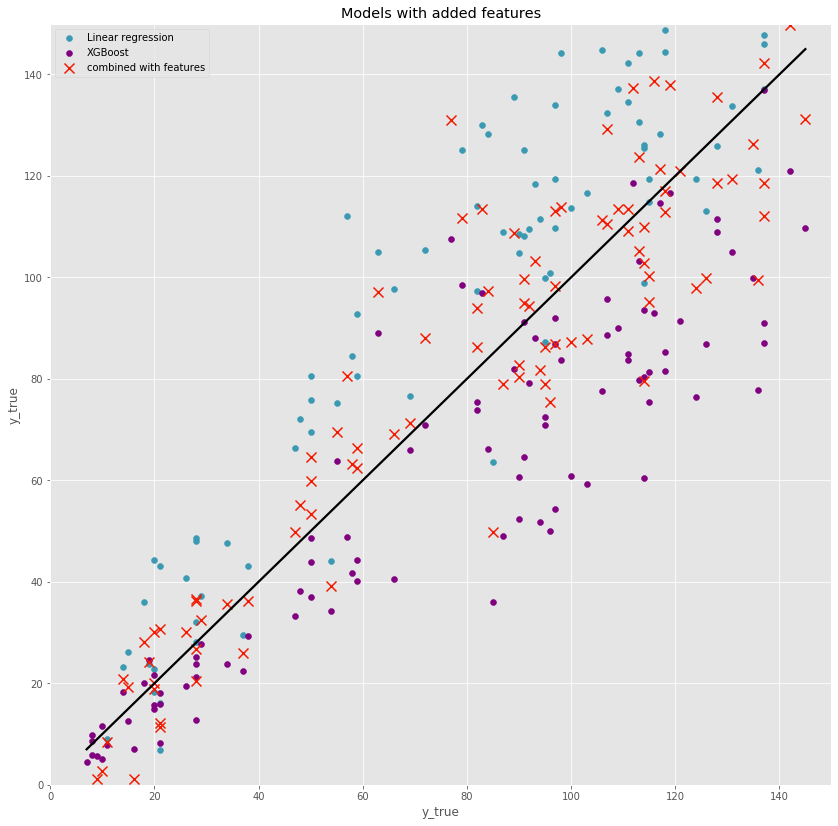

In [114]:
fig = plt.subplots(figsize=(14,14))
axes = plt.gca()
axes.set_ylim([0,150])
axes.set_xlim([0,150])

plt.scatter(y_test, y_test_predict, label='Linear regression', color=colors[0])
plt.scatter(y_test, preds, label='XGBoost', color='purple')
plt.scatter(y_test, combined_pred, label='combined with features', color=colors[2], s=100, marker='x')

sns.regplot(y_test, y_test, color='black', scatter=False)

plt.legend()
plt.title('Models with added features')
plt.xlabel('y_true')
plt.ylabel('y_true')
plt.show()

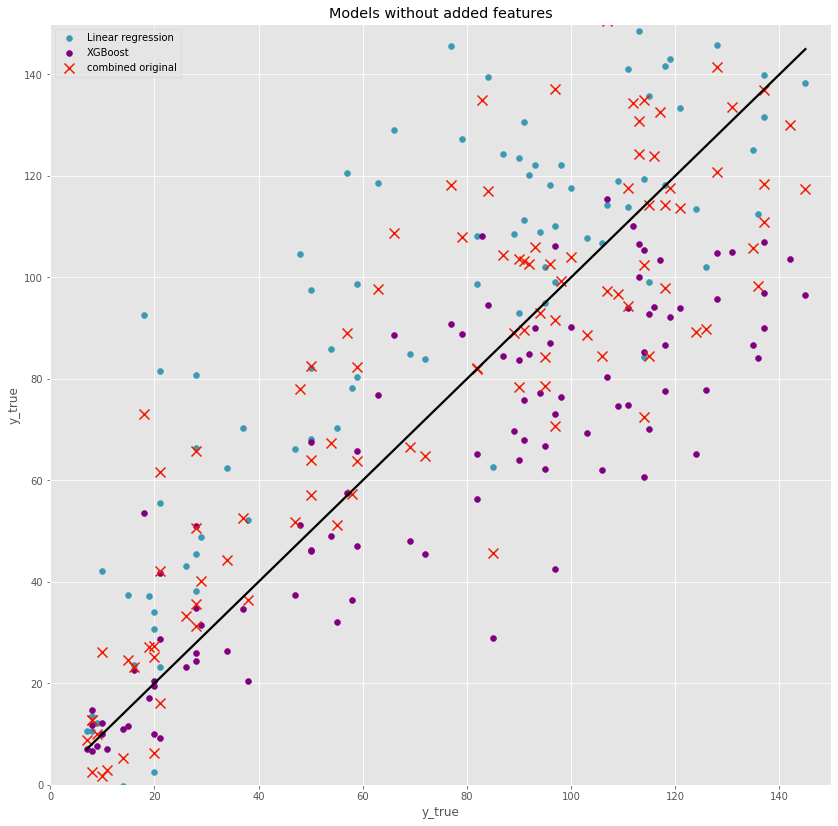

In [117]:
fig, ax = plt.subplots(figsize=(14,14))
axes = plt.gca()
axes.set_ylim([0,150])
axes.set_xlim([0,150])

plt.scatter(y_test_original, y_test_predict_orig, label='Linear regression', color=colors[0])
plt.scatter(y_test_original, preds_orig, label='XGBoost', color='purple')
plt.scatter(y_test_original, combined_pred_original, label='combined original', color=colors[2], s=100, marker='x')

sns.regplot(y_test_original, y_test_original, color='black', scatter=False)

plt.legend()
plt.xlabel('y_true')
plt.ylabel('y_true')
plt.title('Models without added features')
plt.show()

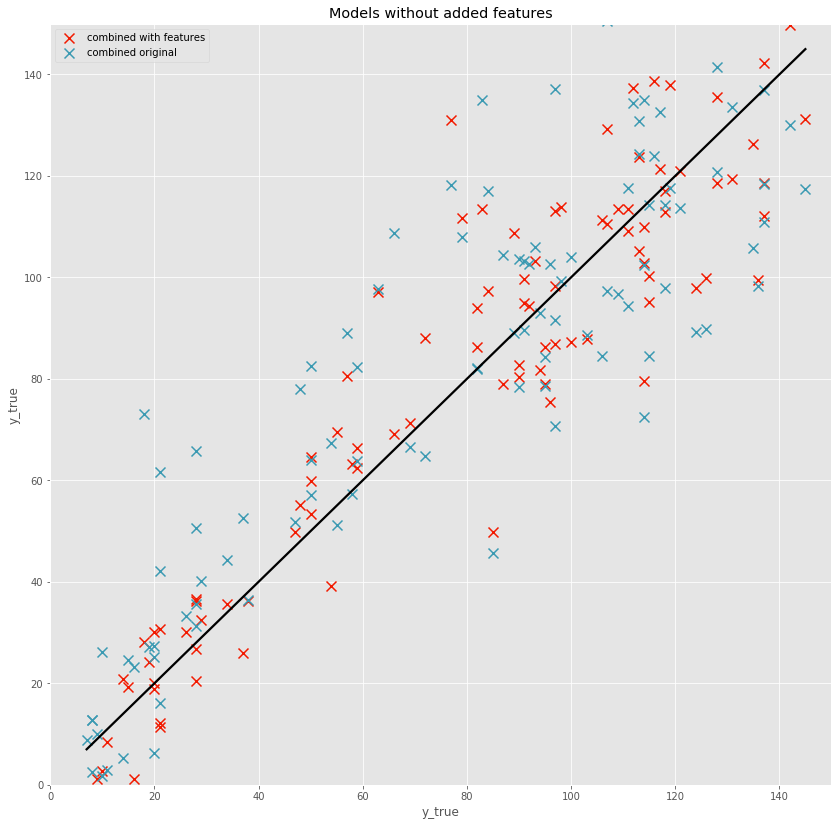

In [118]:
fig, ax = plt.subplots(figsize=(14,14))
axes = plt.gca()
axes.set_ylim([0,150])
axes.set_xlim([0,150])

plt.scatter(y_test, combined_pred, label='combined with features', color=colors[2], s=100, marker='x')
plt.scatter(y_test_original, combined_pred_original, label='combined original', color=colors[0], s=100, marker='x')

sns.regplot(y_test_original, y_test_original, color='black', scatter=False)

plt.legend()
plt.xlabel('y_true')
plt.ylabel('y_true')
plt.title('Combined models')
plt.show()